# Week 8 - Semantic Networks - Bayesian Echo Chamber

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#All these packages need to be installed from pip

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #MAkes the plots look nice
import IPython.display #For displaying images

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline


import sys
import subprocess

import pickle #if you want to save layouts
import os

# Bayesian Echo Chamber

## Example

In [2]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

### Your own dataset should contains 4 columns(with the same column names)  as the faked one below
- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minute','hour'...)
- end: ending time of utterance


No need to sort data for the moment

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript.head(2)

In [3]:
def make_TalkbankXML(df,fname,database='my_dataset',language='eng'):
    '''
    This function will transform pandas dataframe into TalkbankXML for Bayesian estimation of influence.
    
    df:  pandas dataframe of utterences, need four columns: "name", "tokens", "start", "end".  
    ("start", "end" is the start_time, and end_time of a utterence)
    
    fname:  file name to save xml output
    database: (arbitrary) name of your database 
    language: 'eng' is the default. (currently also support 'chinese')
    
    Important: All non-English tokens and names should be unicode. 
    '''
    
    
    #format dataframe
    df = df[['name','tokens','start','end']]
    unit='s'
    df['start'] = df['start'].apply(pd.to_numeric)
    df['end'] = df['end'].apply(pd.to_numeric)
    df = df.dropna() # only allow non-missing data
    df = pd.DataFrame(sorted(df.values.tolist(),key=lambda x:x[2]),columns=df.columns) #sort by time
    
    #generate xml
    fname_short = fname
    if os.path.sep in fname:
        new_path = "."+os.path.sep+'data'+os.path.sep+fname.split(os.path.sep)[-1].split('.')[0]+os.path.sep
        fname_short = fname.split(os.path.sep)[-1].split(os.path.sep)[0]
    else:
        new_path = "."+os.path.sep+'data'+os.path.sep+fname.split('.')[0]+os.path.sep
    if not '.' in fname_short:
        fname_short+='.xml'
    else:
        fname_short = fname_short.split('.')[0]+'.xml'
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    
    
    
    with open(new_path+fname_short,'w') as fw:
        print ('<?xml version="1.0" encoding="UTF-8"?>\n',file=fw)
        print ('<CHAT from="%s">' % database,file=fw)
        
        #create person_ids
        person_id ={}
        for person in set(df_transcript['name'].values.tolist()):
            if not person in person_id: person_id[person] = len(person_id)+1
        
        #add participants 
        print ('<Participants>',file=fw)
        for person in person_id:
            print ('<participant id="%s" name="%s" role="Adult" language="%s"/>' %(person,person,language),file=fw)
        print ('</Participants>\n',file=fw)   
        
        #add utterences
        for row in df.values:
            print ('<u who="%s" uID="#%s">' % (row[0],person_id[row[0]]),file=fw)
            for word in row[1]:
                print ('''<w>%s</w>''' % word, file=fw)
               
            print ('''<media start="%s" end="%s" unit="%s"/>''' %(row[2],row[3],unit),file=fw)
            print ('''</u>''',file=fw)
            print ('''''', file=fw)
        print ("</CHAT>\n",file=fw)
    
    
    print ('New File saved to %s' % new_path+fname_short)
    return 0
    

### Transform data into TalkbankXML format

In [4]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
make_TalkbankXML(df_transcript,output_fname,language =language )

### Run Bayesian Echo Chamber to get estimation.
- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
#output_fname = './data/12-angry-men.xml'   #uncomment this line if want to use the example dataset: "12-angry-men"

In [5]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
subprocess.call(["python", "./src/run_bec.py",output_fname,str(Vocab_size),language,str(int(sampling_time))])


### Realtime output can be viewed in shell.

## Now let's look at the output

Load results

In [6]:
result_path = './results/'+output_fname.split('.')[0]+os.path.sep

In [7]:
df_meta_info = pd.read_table(result_path+ 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path+"SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path+ 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_log_prob.shape,df_influence.shape

((1500, 3), (1500, 100))

In [8]:
df_participants = pd.read_csv(result_path+ 'cast.txt',delim_whitespace=True) #
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()

In [9]:
person_id

{'Bush': 6,
 'Carter': 1,
 'Clinton': 3,
 'Ford': 2,
 'Kennedy': 8,
 'Nixon': 4,
 'Obama': 5,
 'Reagan': 9,
 'Roosevelt': 0,
 'Trump': 7}

In [10]:
from scipy.stats import gaussian_kde

In [11]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = gaussian_kde(data)
    width = np.max(data)-np.min(data)
    xs = np.linspace(np.min(data)-width/5,np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs,density(xs)

## Plot MCMC trace and density of log-likelihoods

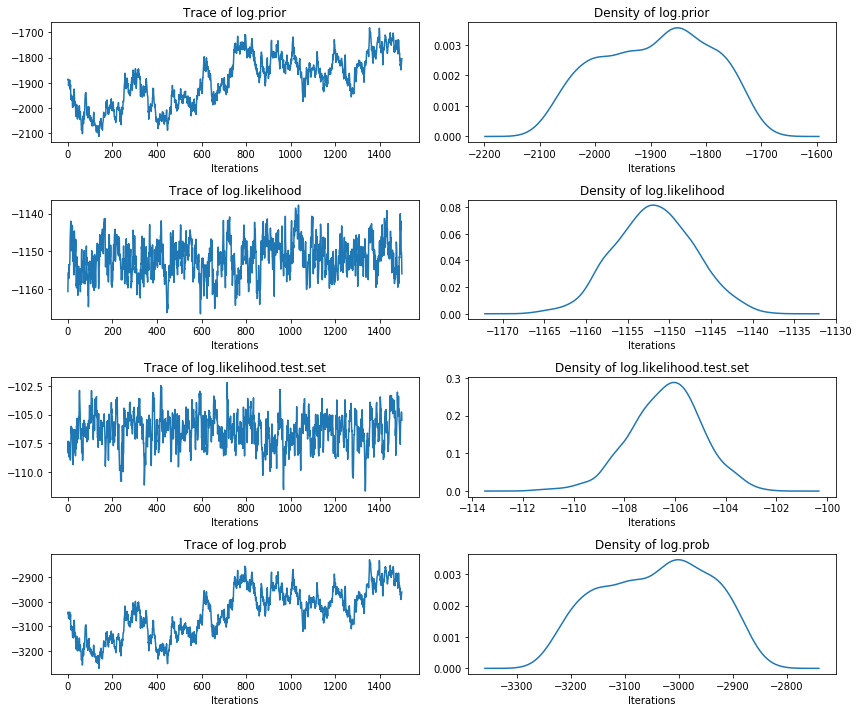

In [12]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

## Plot Influence Matrix between participants

In [77]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [78]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [79]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [80]:
df_mean

,Roosevelt,Carter,Ford,Clinton,Nixon,Obama,Bush,Trump,Kennedy,Reagan
Roosevelt,0.000000,1.686122,0.514158,0.442414,0.535487,0.180771,0.742695,0.437906,0.774469,0.708715
Carter,0.389750,0.000000,0.306749,0.389610,0.674380,0.539554,0.410608,0.311959,0.525197,0.234382
Ford,0.267023,0.382702,0.000000,0.709231,0.533327,0.517623,0.456482,0.683771,0.834791,1.139308
Clinton,0.470664,0.191309,0.584892,0.000000,0.432490,0.349985,0.257269,0.623406,0.538033,1.028876
Nixon,0.293051,0.494523,0.940197,0.338764,0.000000,0.566164,1.066566,0.380905,0.710383,0.333918
Obama,0.367804,0.459635,0.342514,0.307656,0.542003,0.000000,0.318903,0.478295,0.847632,0.614754
Bush,0.629534,0.396142,0.516609,0.721672,0.504813,0.330279,0.000000,0.338581,0.635737,0.374300
Trump,0.614435,0.290174,0.746918,0.479732,0.341979,0.371742,0.403480,0.000000,0.661003,0.696562
Kennedy,0.586597,0.253997,0.369036,0.652950,0.685889,0.740387,1.000608,0.484032,0.000000,0.422358
Reagan,0.529695,0.747348,0.672232,0.967873,0.182236,0.743004,0.225367,0.322579,0.391846,0.000000


MEAN of influence matrix (row=from, col=to)


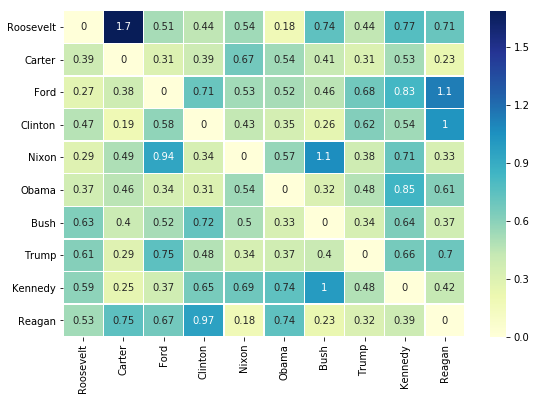

In [17]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


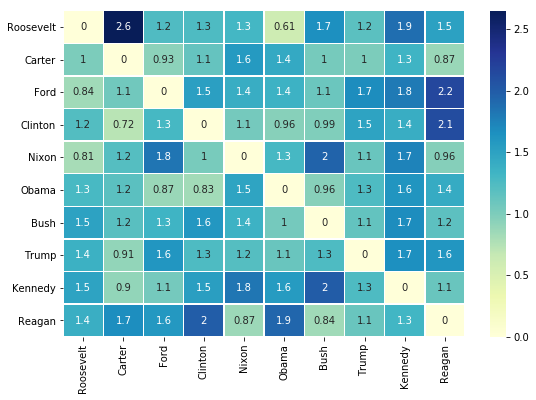

In [18]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

In [19]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

# Barplot of total influences sent/received

In [144]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

### Total influence

		Total linguistic influence sent/received 


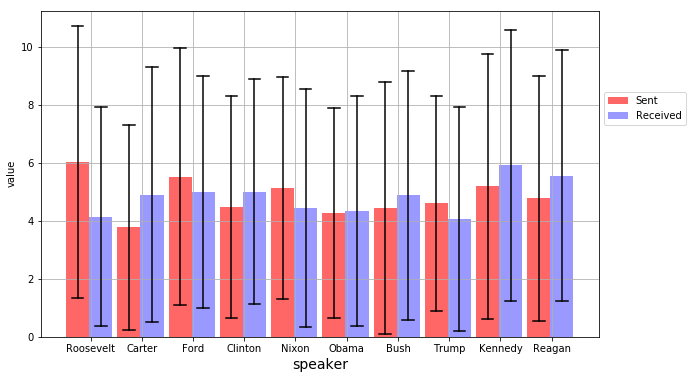

In [214]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

# Visualize Influence Network!
- you can visualize any of the influence matrices above

## Using networkx

In [20]:
import networkx as nx

In [21]:
def drawNetwork(df):
    G = nx.Graph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
    return G

Mean Influence Network


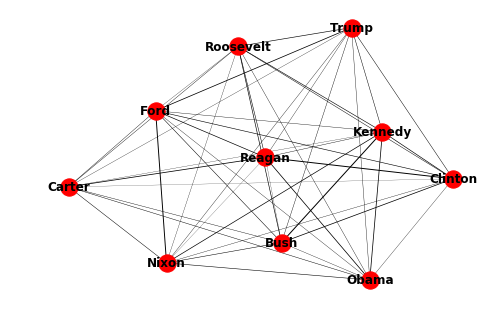

In [24]:
G_mean = drawNetwork(df_mean)
edges,weights = zip(*nx.get_edge_attributes(G_mean,'weight').items())
print('Mean Influence Network')
nx.draw(G_mean,with_labels=True, font_weight='bold',width=weights)

25 Quantile Influence Network


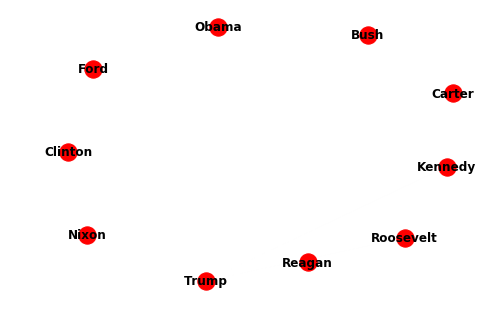

In [25]:
G_q25 = drawNetwork(df_q25)
edges,weights = zip(*nx.get_edge_attributes(G_q25,'weight').items())
print('25 Quantile Influence Network')
nx.draw(G_q25,with_labels=True, font_weight='bold',width=weights)

75 Quantile Influence Network


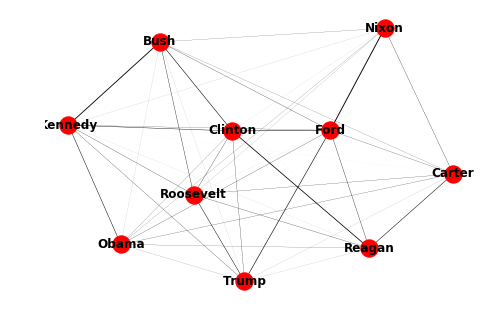

In [26]:
G_q75 = drawNetwork(df_q75)
edges,weights = zip(*nx.get_edge_attributes(G_q75,'weight').items())
print('75 Quantile Influence Network')
nx.draw(G_q75,with_labels=True, font_weight='bold',width=weights)